In [1]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

## How many states can you disambiguate 

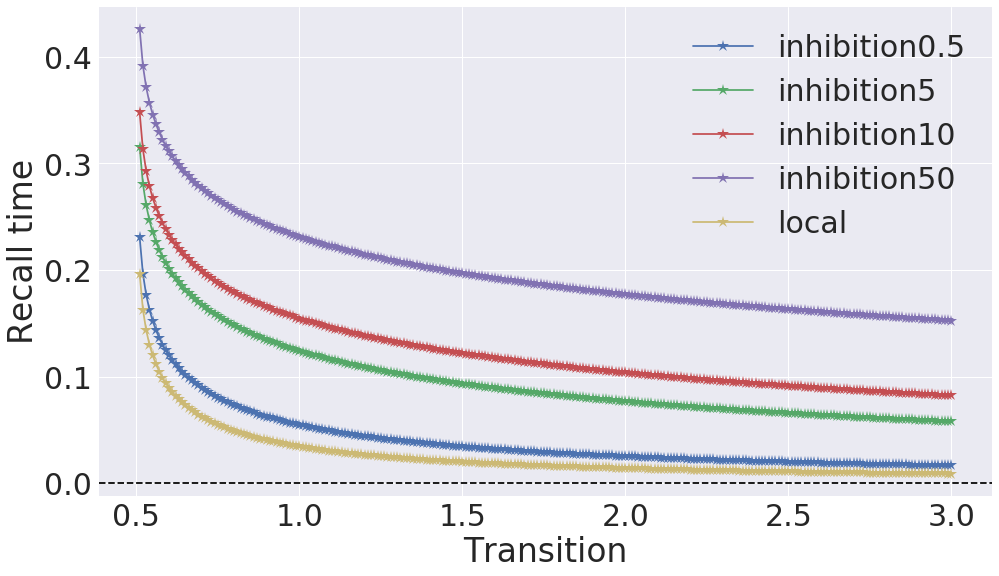

In [2]:
transition_vector = np.arange(0.51, 3.0, 0.01)
inhibitions = [0.5, 5, 10, 50]
threshold = 0.5
tau_z = 0.050

for inhibition in inhibitions:
    T1_theo = tau_z * np.log((transition_vector + inhibition) / (transition_vector - threshold))
    plt.plot(transition_vector, T1_theo, '*-', markersize=13, label='inhibition' + str(inhibition))

T1_theo_local = tau_z * np.log(transition_vector/ (transition_vector - threshold))


plt.plot(transition_vector, T1_theo_local, '*-', markersize=13, label='local')
plt.axhline(0, ls='--', color='black')
plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

It seems that the disambiguation capacity of the system is really low. What if we did not have the lower limit for transition

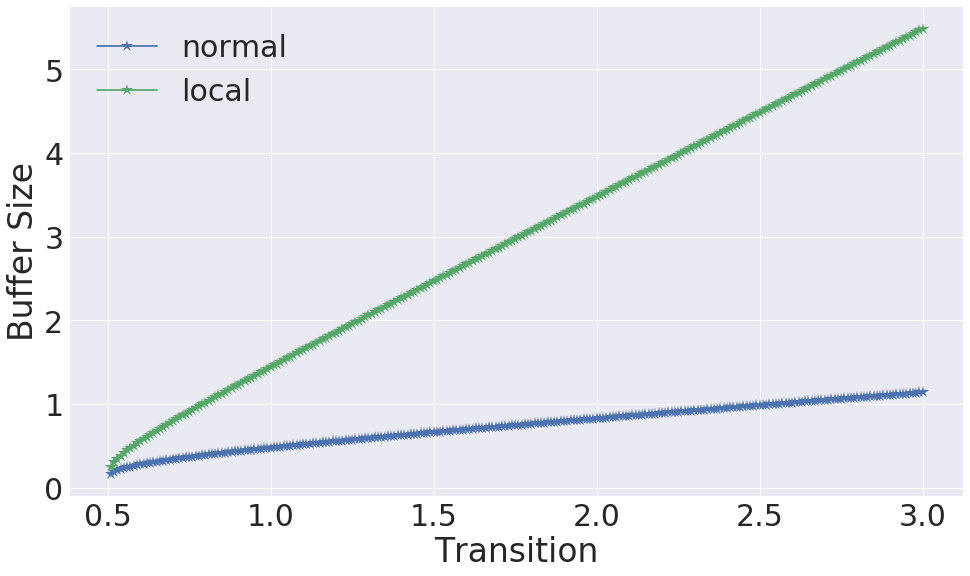

In [3]:
inhibition = 3.0
T1_theo = tau_z * np.log((transition_vector + inhibition) / (transition_vector - threshold))
buffer_size = tau_z / T1_theo
buffer_size_local = tau_z / T1_theo_local

plt.plot(transition_vector, buffer_size, '*-', markersize=13, label='normal')
plt.plot(transition_vector, buffer_size_local, '*-', markersize=13, label='local')

plt.xlabel('Transition')
plt.ylabel('Buffer Size')
plt.legend();

This means that the local rule is better at disambiguation than the normal one. 

It is reasonable to use big inhibition so we will try a variation for tau_z with transition equal to 1.5 or in the middle of the plot above

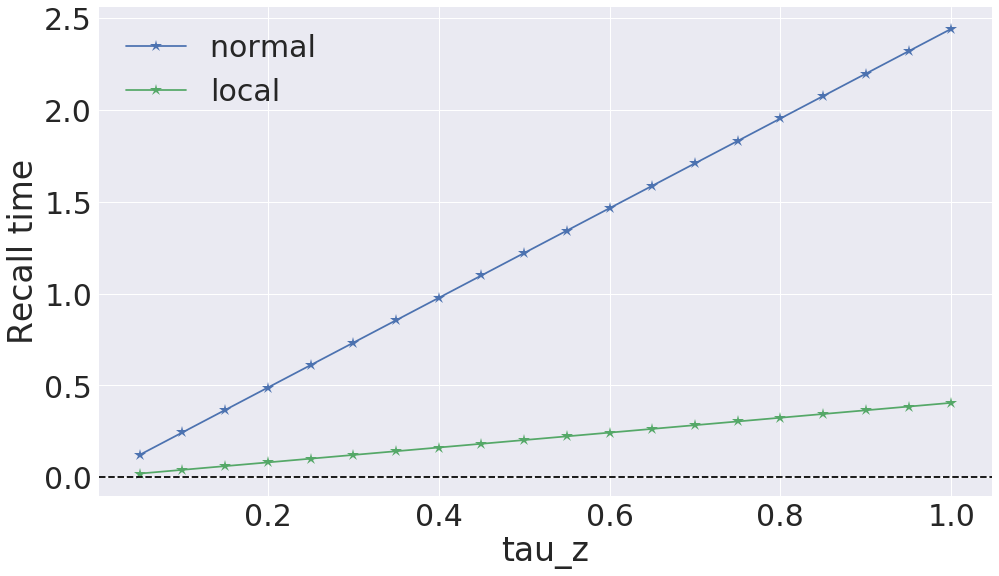

In [4]:
transition = 1.5
inhibition = 10.0
threshold = 0.5
tau_z_vector = np.arange(0.050, 1.050, 0.050)

T1_theo = tau_z_vector * np.log((transition + inhibition) / (transition - threshold))
T1_theo_local = tau_z_vector * np.log(transition/ (transition - threshold))


plt.plot(tau_z_vector, T1_theo, '*-', markersize=13, label='normal ')
plt.plot(tau_z_vector, T1_theo_local, '*-', markersize=13, label='local')
plt.axhline(0, ls='--', color='black')
plt.xlabel('tau_z')
plt.ylabel('Recall time')
plt.legend();

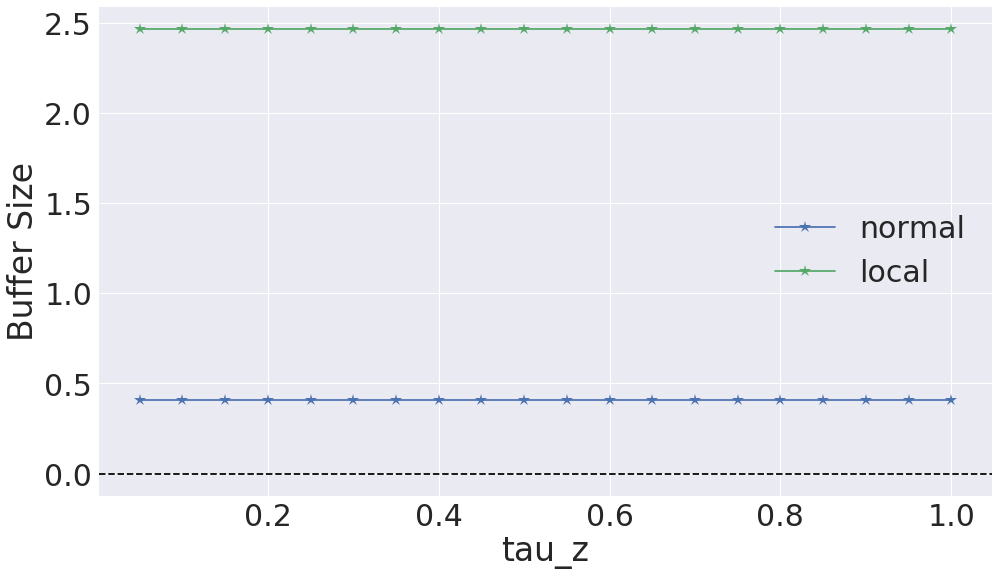

In [5]:
buffer_size = tau_z_vector / T1_theo
buffer_size_local = tau_z_vector / T1_theo_local

plt.plot(tau_z_vector, buffer_size, '*-', markersize=13, label='normal')
plt.plot(tau_z_vector, buffer_size_local, '*-', markersize=13, label='local')


plt.axhline(0, ls='--', color='black')
plt.xlabel('tau_z')
plt.ylabel('Buffer Size')
plt.legend();

## Working example of overlap

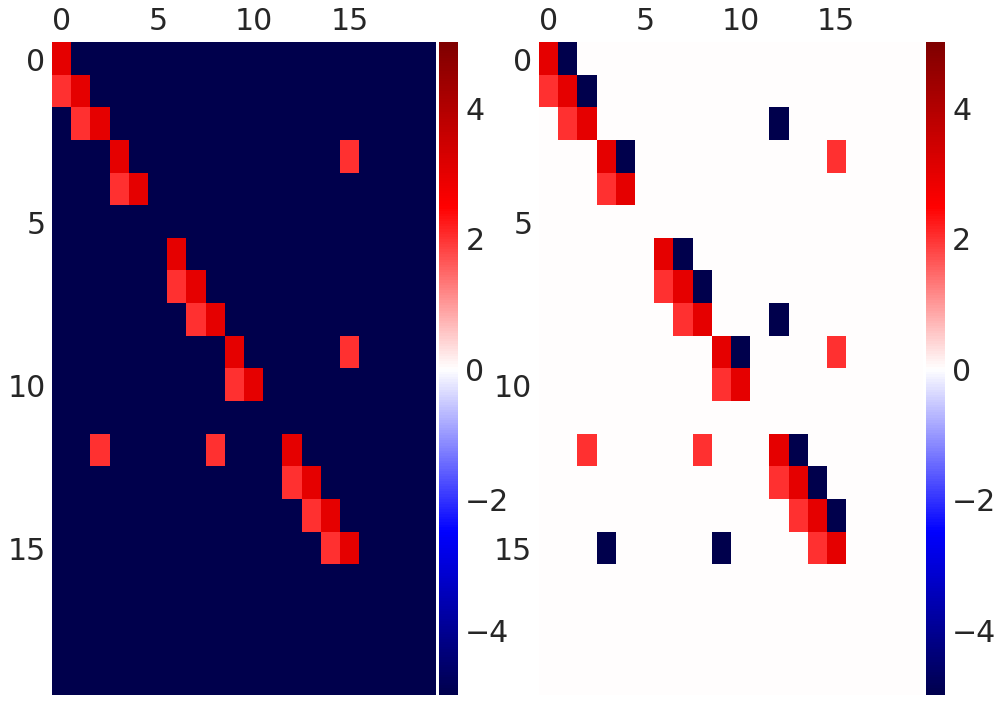

In [6]:
N = 20

dt = 0.0005
tau_m = 0.010

G = 100.0
self_excitation = 3.0
inhibition = 5.0
transition = 2.0
threshold = 0.5

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]
w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)

w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhibition=inhibition)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

symmetric = np.max((np.max(w1), np.abs(np.min(w1))))
im1 = ax1.matshow(w1, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax1.grid()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)


symmetric = np.max((np.max(w2), np.abs(np.min(w2))))
im2 = ax2.matshow(w2, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax2.grid()
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2);

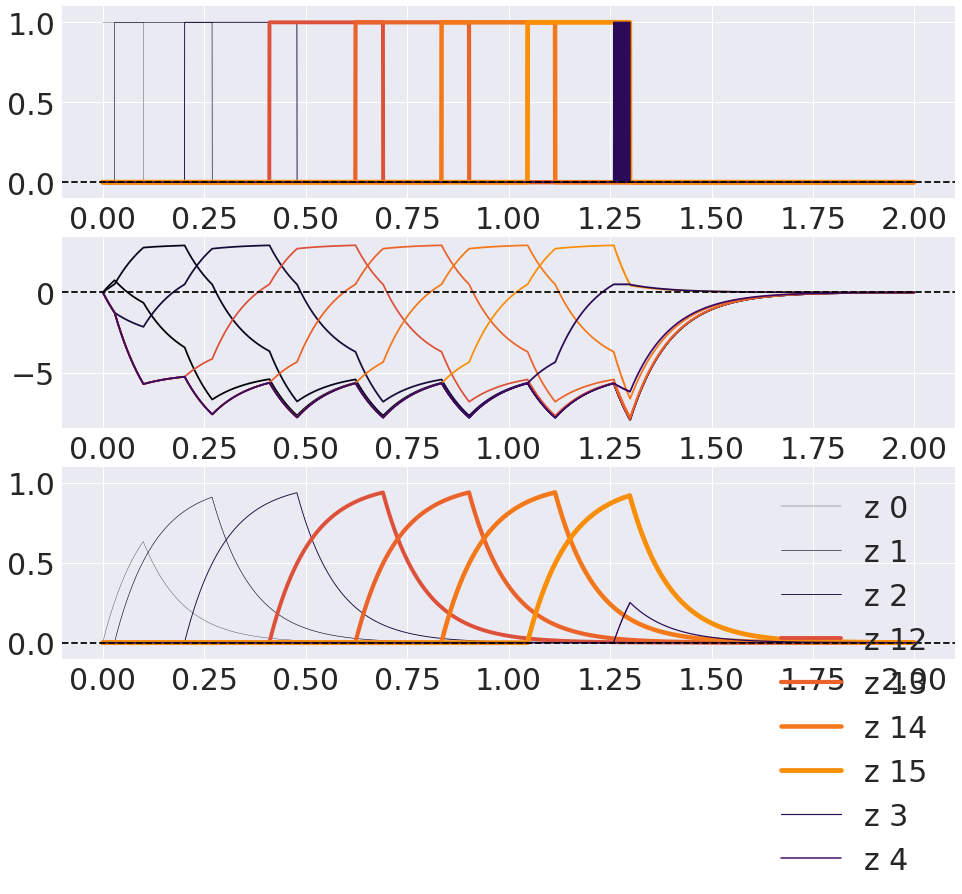

In [7]:
-

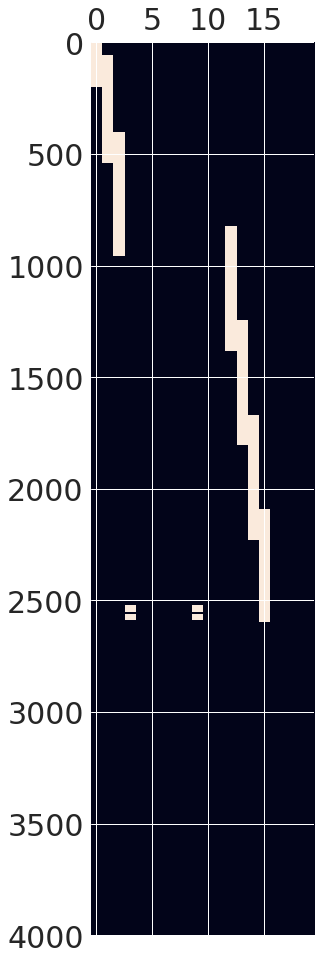

In [8]:
plt.matshow(x_history, aspect='auto')

What we see here is that the local system recalls both and the system with more inhibition stays undecisive at the bifurcation. This make sense. 

The effect mentioned above also happens for big and small tau_Z

Let's try to do some 

## Cosine Similiarty to patterns
Let's buld a function that will give us the distance to the patterns at the end

In [9]:
patterns_matrix = np.eye(N)

x = patterns_matrix[1]
y = x_history[0, :]

def cosine_similarity(x, y):
    
    cosine = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cosine

similarity_matrix = np.zeros_like(x_history)

for x_index, x in enumerate(x_history):
    for index, pattern in enumerate(patterns_matrix):
        similarity_matrix[x_index, index] = cosine_similarity(pattern, x)
        

/home/heberto/miniconda/envs/firing_rate_sequences/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


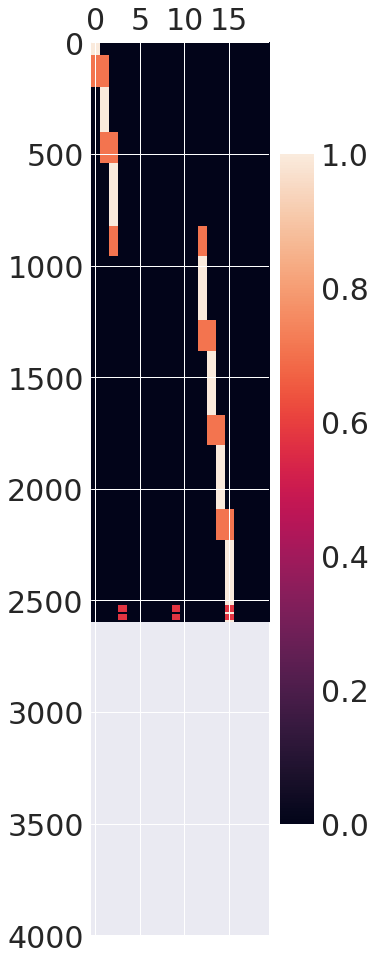

In [10]:
plt.matshow(similarity_matrix, aspect='auto')
plt.colorbar()

In [11]:
similarity_matrix[-1, :]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [12]:
x_history[-1, :]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

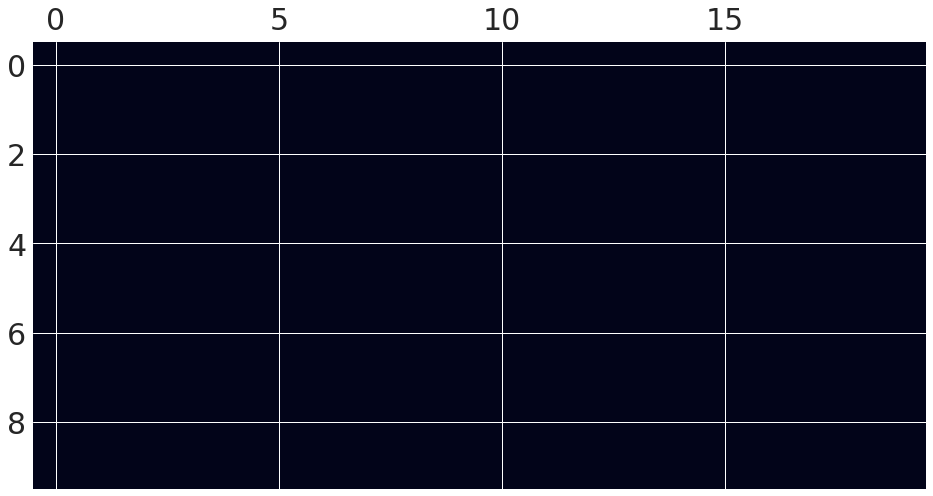

In [13]:
plt.matshow(x_history[-10:, :])

It seems that it will be enough to just take the final vector of x_history as an indicator of value

## Artificial added value

Same case as above but now we add the connections to bridge the overlap

In [14]:
N = 20

dt = 0.0005

G = 100.0
self_excitation = 5.0
inhibition = 20.0
transition = 3.0
threshold = 0.5

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]
w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)

w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhibition=inhibition)

2 to 9 -20.0
8 to 3 -20.0


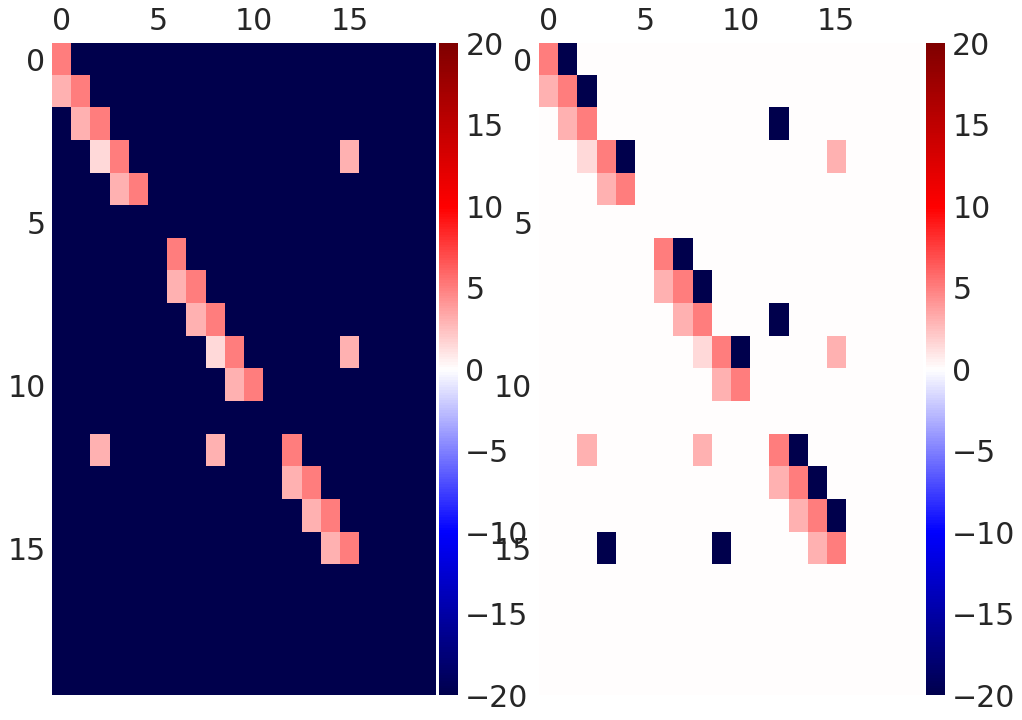

In [15]:
# Artificially added values
aux = transition * 0.5
w1[3, 2] = aux
w1[9, 8] = aux
w2[3, 2] = aux
w2[9, 8] = aux

print('2 to 9', w1[9, 2])
print('8 to 3', w1[3, 8])

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

symmetric = np.max((np.max(w1), np.abs(np.min(w1))))
im1 = ax1.matshow(w1, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax1.grid()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)


symmetric = np.max((np.max(w2), np.abs(np.min(w2))))
im2 = ax2.matshow(w2, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')

ax2.grid()
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2);

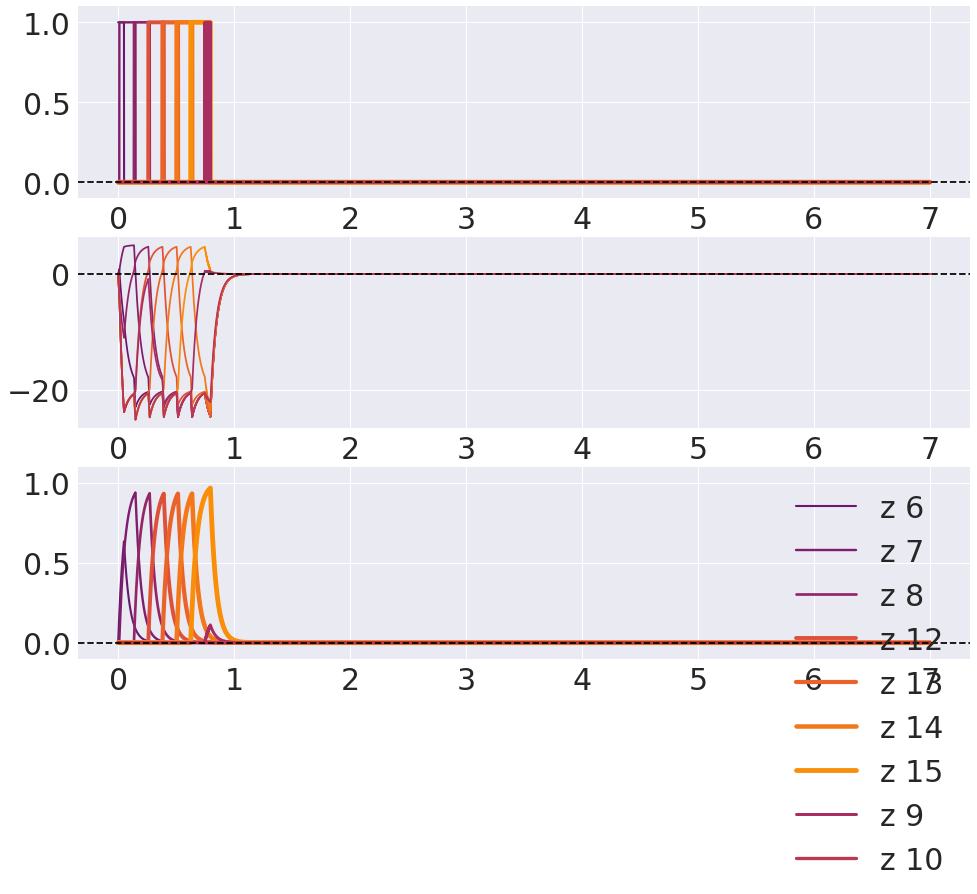

In [16]:
tau_z = 0.050
sigma = 0.0
w = w1

sequence_to_recall = sequences[1]
I_cue = sequence_to_recall[0]
T = 7.0
T_cue = tau_z

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

time = np.arange(0, T, dt)

norm = matplotlib.colors.Normalize(0, N)
cmap = matplotlib.cm.inferno

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = sequence_to_recall
for pattern in patterns:
    width = pattern * 0.3 + 0.3
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)),linewidth=width, label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], color=cmap(norm(pattern)), linewidth=width, label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
# ax1.legend();

ax1.set_ylim([-0.1, 1.1])
# ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
# ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

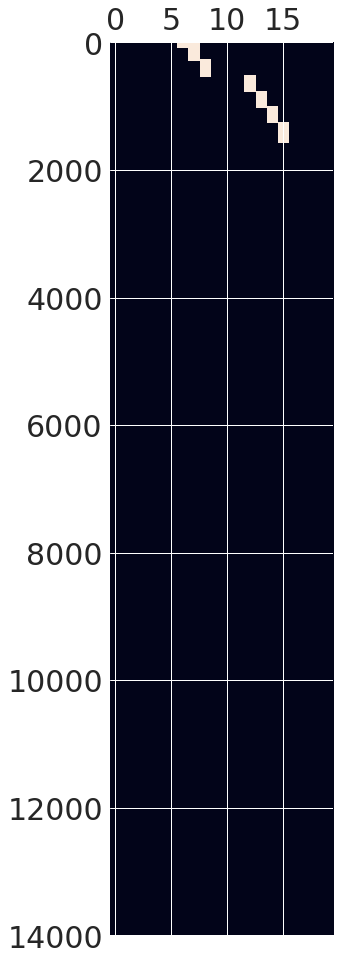

In [17]:
plt.matshow(x_history, aspect='auto')

It seems that it works for most values of z. Let's try this systematicallly. To this I need to exract the last value of x_history and check that indeed indeed x_history[sequence[-1]] = 1.0. That is, that x_history ends in the last element of the sequence

In [18]:
ends = np.where(x_history[-1] > 0.5)[0]
should_be = sequence_to_recall[-1]

print(ends)
print(should_be)

[]
10


In [19]:
N = 20

dt = 0.0005

G = 100.0
self_excitation = 5.0
inhibition = 30.0
transition = 3.0
threshold = 0.5

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]
w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)

w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhibition=inhibition)

# Artificially added values
aux = transition * 0.5
w1[3, 2] = aux
w1[9, 8] = aux
w2[3, 2] = aux
w2[9, 8] = aux

In [20]:
tau_z = 0.050
sigma = 0.0
w = w1

tau_z_vector = np.arange(0.050, 0.550, 0.050)
success_array = np.zeros((tau_z_vector.size, 2))

for tau_z_index, tau_z in enumerate(tau_z_vector):
    print(tau_z_index)
    for i in range(len(sequences)):
        T = 7.0
        T_cue = tau_z
        sequence_to_recall = sequences[i]
        I_cue = sequence_to_recall[0]
        dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
        x_history = dic['x']
        
        # If the last element is zero or more than 1
        hits = x_history[-1].sum()
        if  hits < 0.1 or hits > 1.5 :
            success = 0.0
        else:
            ends = np.where(x_history[-1] > 0.5)[0]
            should_be = sequence_to_recall[-1]
            success = np.abs(ends - should_be) < 0.1
        
        success_array[tau_z_index, i] = success


0
1
2
3
4
5
6
7
8
9


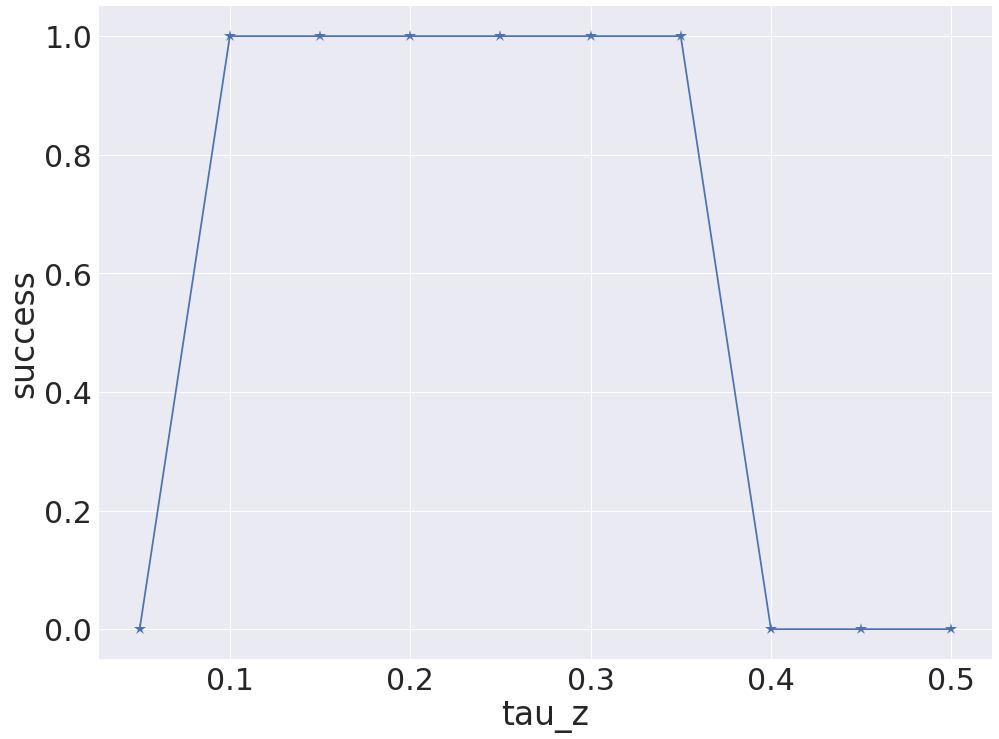

In [21]:
success_tau_z = np.mean(success_array, axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln = ax.plot(tau_z_vector, success_tau_z, '*-', markersize=13)

ax.set_xlabel('tau_z')
ax.set_ylabel('success')

We see that indeed it converges for most reasonable values of tau_z, why? I think the answer can be obtained by probing deper on the nature of of the other parameters, transition and self-excitation

In [32]:
N = 20
T = 7.0

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]

dt = 0.0005
tau_z = 0.100
sigma = 0.0

G = 100.0
self_excitation = 3.0
inhibition = 10.0
transition = 1.5
threshold = 0.5

transition_vector = np.arange(0.6, 3.6, 0.5)
self_excitation_vector = np.arange(1.0, 6.0, 1.0)
success_array = np.zeros((transition_vector.size, self_excitation_vector.size, 2))

for t_index, transition in enumerate(transition_vector):
    print(transition)
    for A_index, self_excitation in enumerate(self_excitation_vector):
        w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)
        w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                                             inhibition=inhibition)

        # Artificially added values
        aux = transition * 0.5
        w1[3, 2] = aux
        w1[9, 8] = aux
        w2[3, 2] = aux
        w2[9, 8] = aux
        
        w = w1
        
        for i in range(len(sequences)):
            T_cue = tau_z
            sequence_to_recall = sequences[i]
            I_cue = sequence_to_recall[0]
            dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
            x_history = dic['x']

            # If the last element is zero
            hits = x_history[-1].sum()
            if hits < 0.1 or hits > 1.5:
                success = 0.0
            else:
                ends = np.where(x_history[-1] > 0.5)[0]
                should_be = sequence_to_recall[-1]
                success = np.abs(ends - should_be) < 0.1

            success_array[t_index, A_index, i] = success

            success_array[t_index, A_index, i] = success



0.6
1.1
1.6
2.1
2.6
3.1


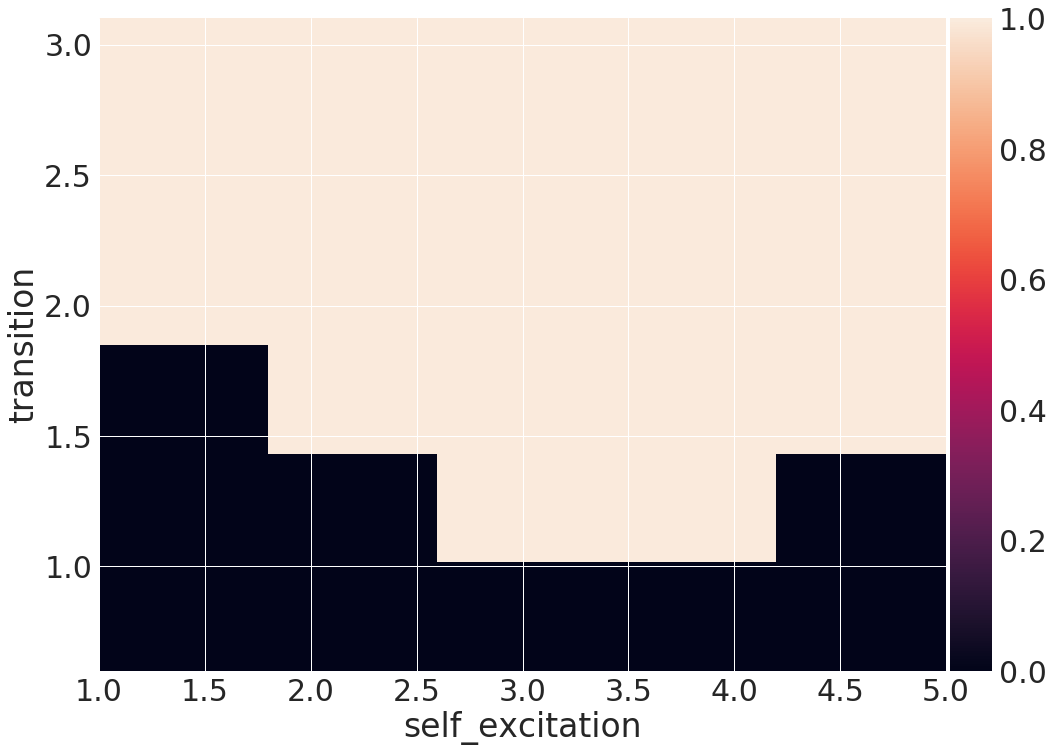

In [33]:
aux = np.mean(success_array, axis=2)

extent = [self_excitation_vector[0], self_excitation_vector[-1], transition_vector[0], transition_vector[-1]]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(aux, aspect='auto', origin='lower', extent=extent)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xlabel('self_excitation')
ax.set_ylabel('transition')

There are two ways in which this could be succesfful:
* The **normal** theory. Where because of the effects of the filter the information gets propagated through the T matrix.
* The **inhibition** theory, the system gets less inhibition. 

If the second is true, then just suppressing the positive connection, make it zero should keep most the success recall beecause there is still less inhibition even if there is no transition information flowing to the bridge.

In [40]:
N = 20
T = 7.0

sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]

dt = 0.0005
tau_z = 0.100
sigma = 0.0

G = 100.0
self_excitation = 3.0
inhibition = 10.0
transition = 1.5
threshold = 0.5

transition_vector = np.arange(0.6, 3.6, 0.5)
self_excitation_vector = np.arange(1.0, 6.0, 1.0)
success_array = np.zeros((transition_vector.size, self_excitation_vector.size, 2))

for t_index, transition in enumerate(transition_vector):
    print(transition)
    for A_index, self_excitation in enumerate(self_excitation_vector):
        
        w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)
        w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                                      inhibition=inhibition)

        # Artificially added values
        if True:
            aux = transition * 0.5
            aux = 0
            w1[3, 2] = aux
            w1[9, 8] = aux
            w2[3, 2] = aux
            w2[9, 8] = aux
        
        w = w1
        
        for i in range(len(sequences)):
            T_cue = tau_z
            sequence_to_recall = sequences[i]
            I_cue = sequence_to_recall[0]
            dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
            x_history = dic['x']
            last_pattern = x_history[-1]
            # If the last element is zero
            hits = last_pattern.sum()
            if hits < 0.1 or hits > 1.5:
                success = 0.0
            else:
                ends = np.where(last_pattern > 0.5)[0]
                should_be = sequence_to_recall[-1]
                success = np.abs(ends - should_be) < 0.1

            success_array[t_index, A_index, i] = success

            success_array[t_index, A_index, i] = success



0.6
1.1
1.6
2.1
2.6
3.1


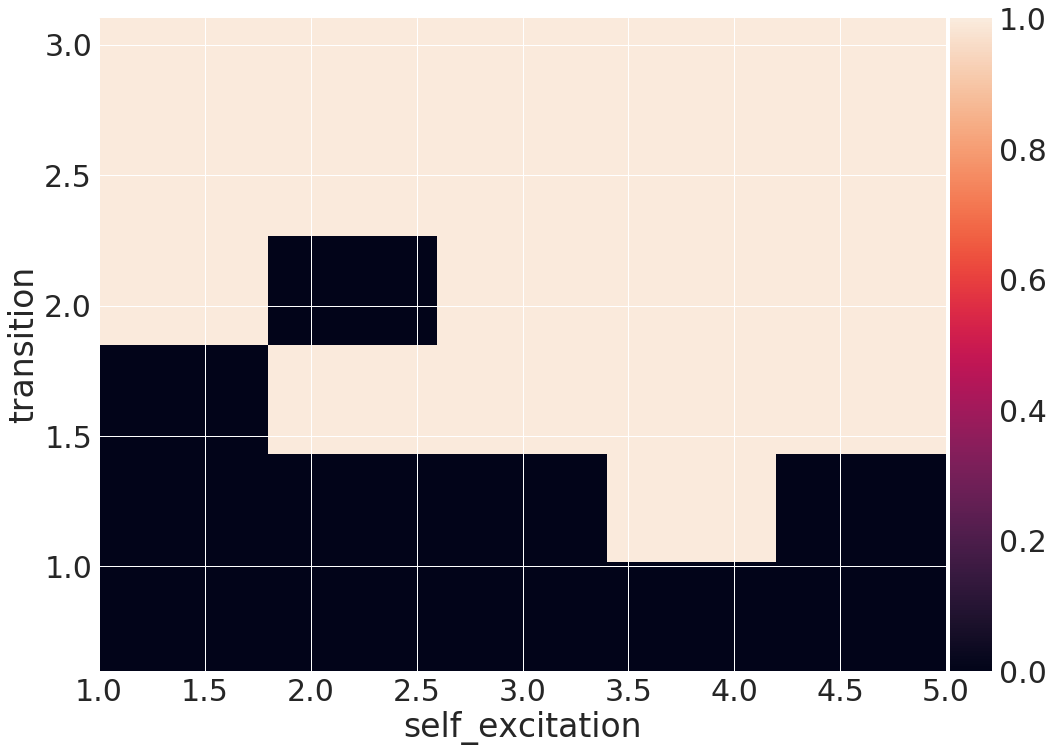

In [35]:
aux = np.mean(success_array, axis=2)

extent = [self_excitation_vector[0], self_excitation_vector[-1], transition_vector[0], transition_vector[-1]]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(aux, aspect='auto', origin='lower', extent=extent)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xlabel('self_excitation')
ax.set_ylabel('transition')

The effect of a longer bridge

In [36]:
N = 20
T = 15.0

sequences = [[0, 1, 2, 12, 13, 14, 15, 16, 17, 18, 3, 4], [6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 9, 10]]

dt = 0.0005
tau_z = 0.100
sigma = 0.0

G = 100.0
self_excitation = 3.0
inhibition = 10.0
transition = 1.5
threshold = 0.5

transition_vector = np.arange(0.6, 3.6, 0.5)
self_excitation_vector = np.arange(1.0, 6.0, 1.0)
success_array = np.zeros((transition_vector.size, self_excitation_vector.size, 2))

for t_index, transition in enumerate(transition_vector):
    print(transition)
    for A_index, self_excitation in enumerate(self_excitation_vector):
        w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)
        w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                                      inhibition=inhibition)

        # Artificially added values
        aux = transition * 0.5
        w1[3, 2] = aux
        w1[9, 8] = aux
        w2[3, 2] = aux
        w2[9, 8] = aux
        
        w = w1
        
        for i in range(len(sequences)):
            T_cue = tau_z
            sequence_to_recall = sequences[i]
            I_cue = sequence_to_recall[0]
            dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
            x_history = dic['x']

           # If the last element is zero
            hits = x_history[-1].sum()
            if hits < 0.1 or hits > 1.5:
                success = 0.0
            else:
                ends = np.where(x_history[-1] > 0.5)[0]
                should_be = sequence_to_recall[-1]
                success = np.abs(ends - should_be) < 0.1

            success_array[t_index, A_index, i] = success



0.6
1.1
1.6
2.1
2.6
3.1


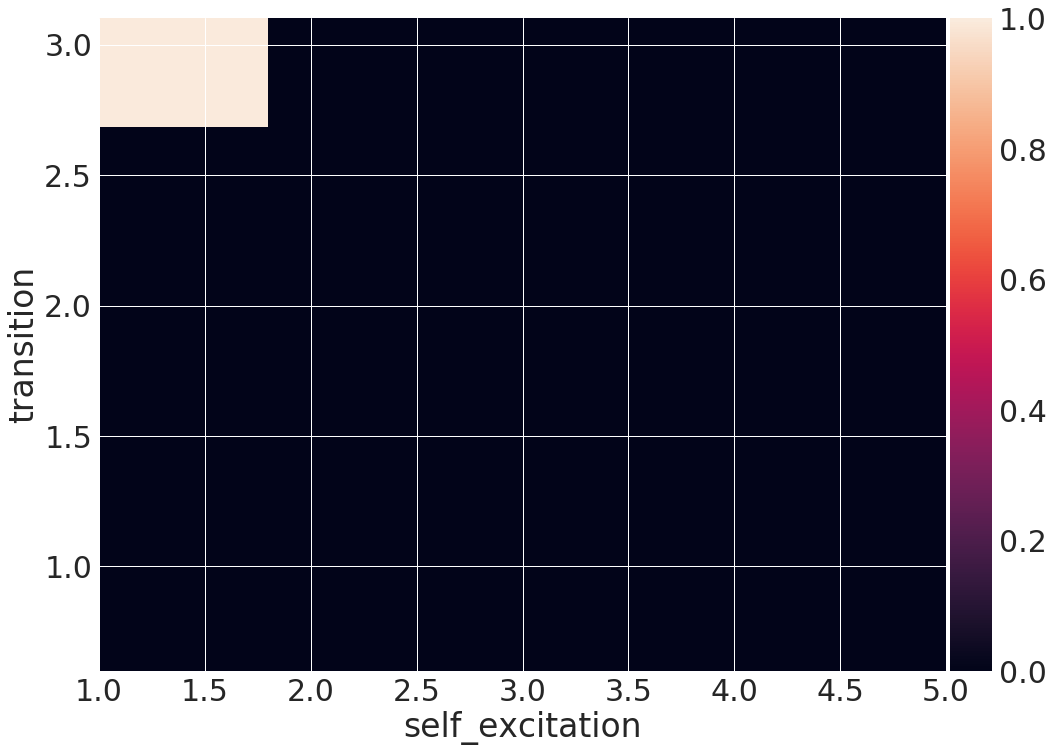

In [37]:
aux = np.mean(success_array, axis=2)

extent = [self_excitation_vector[0], self_excitation_vector[-1], transition_vector[0], transition_vector[-1]]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(aux, aspect='auto', origin='lower', extent=extent)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xlabel('self_excitation')
ax.set_ylabel('transition')

Another way to test this is by using a matrix with the local matrix where there is no inhibition

In [38]:
N = 20
T = 7.0


sequences = [[0, 1, 2, 12, 13, 14, 15, 3, 4], [6, 7, 8, 12, 13, 14, 15, 9, 10]]

dt = 0.0005
tau_z = 0.100
sigma = 0.0

G = 100.0
self_excitation = 3.0
inhibition = 10.0
transition = 1.5
threshold = 0.5

transition_vector = np.arange(0.6, 3.6, 0.5)
self_excitation_vector = np.arange(1.0, 6.0, 1.0)
success_array = np.zeros((transition_vector.size, self_excitation_vector.size, 2))

for t_index, transition in enumerate(transition_vector):
    print(transition)
    for A_index, self_excitation in enumerate(self_excitation_vector):
        w1 = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)
        w2 = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                                      inhibition=inhibition)

        # Artificially added values
        aux = transition * 0.5
        w1[3, 2] = aux
        w1[9, 8] = aux
        w2[3, 2] = aux
        w2[9, 8] = aux
        
        w = w2
        
        for i in range(len(sequences)):
            T_cue = tau_z
            sequence_to_recall = sequences[i]
            I_cue = sequence_to_recall[0]
            dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=sigma)
            x_history = dic['x']

               # If the last element is zero
            hits = x_history[-1].sum()
            if hits < 0.1 or hits > 1.5:
                success = 0.0
            else:
                ends = np.where(x_history[-1] > 0.5)[0]
                should_be = sequence_to_recall[-1]
                success = np.abs(ends - should_be) < 0.1

            success_array[t_index, A_index, i] = success



0.6
1.1
1.6
2.1
2.6
3.1


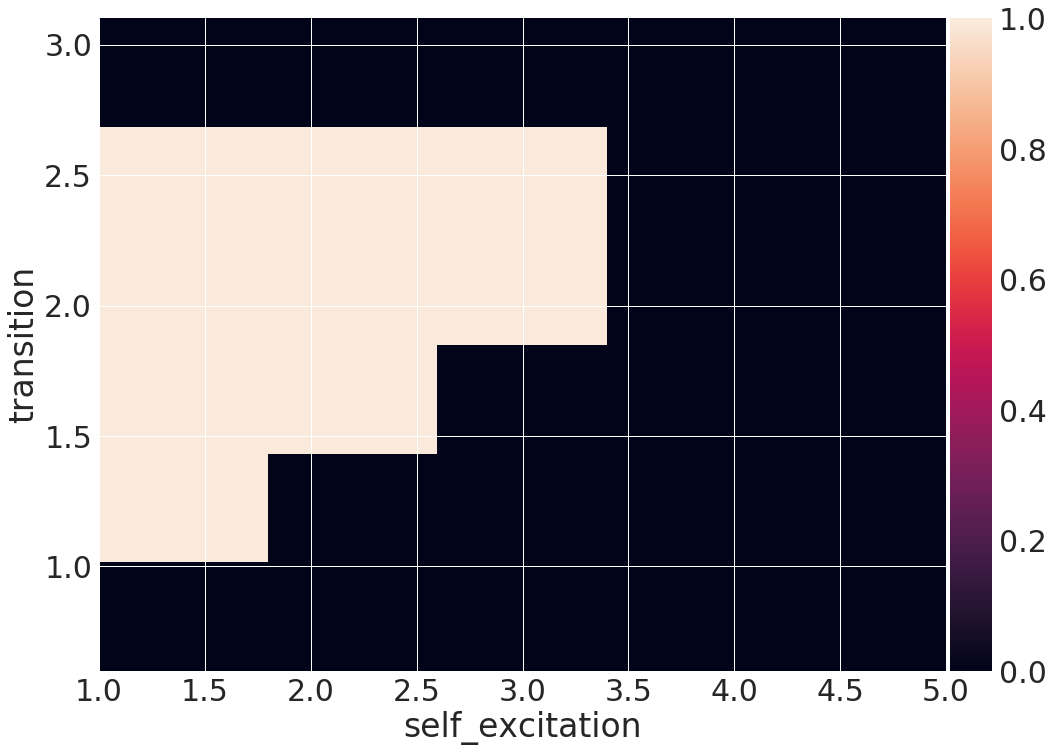

In [39]:
aux = np.mean(success_array, axis=2)

extent = [self_excitation_vector[0], self_excitation_vector[-1], transition_vector[0], transition_vector[-1]]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(aux, aspect='auto', origin='lower', extent=extent)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)4

ax.set_xlabel('self_excitation')
ax.set_ylabel('transition')